In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


poe_path = f"./process_of_elimination.csv"
mcp_path = f"./multiple_choice_prompt.csv"

poe_raw_df = pd.read_csv(poe_path)
mcp_raw_df = pd.read_csv(mcp_path)

In [2]:
def process(df, drop_columns=None): 
    # get rid of identical rows 
    df = df.drop_duplicates()
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df

def process_v2(df, datasets):
    datasets = datasets.split()
    df = df[df["dataset"].isin(datasets)].groupby(["dataset", "checkpoint", "method", "n_shot"])
    df_mean = df.mean().reset_index()
    df_std = df.std().reset_index()
    df_mean = df_mean.drop(columns=["checkpoint"])
    df_std = df_std.drop(columns=["checkpoint"])
    # accuracy: 3 decimal places
    df_mean["accuracy"] = df_mean["accuracy"].apply(lambda x: round(x, 3))
    df_std["accuracy"] = df_std["accuracy"].apply(lambda x: round(x, 3))
    return df_mean, df_std

def process_v3(df):
    # Group the filtered data by dataset and n_shot, calculate the mean accuracy
    df = df.groupby(['method', 'n_shot'])['accuracy'].mean().reset_index()

    # add a colum: dataset, with one value "anli"
    df['dataset'] = 'anli'
    # set "dataset" as the first column
    df = df[['dataset', 'method', 'n_shot', 'accuracy']]
    return df

In [3]:
poe_df = process(poe_raw_df, drop_columns=["prompting_method", "scoring_method", "mask_strategy", "mask_accuracy", "mask_token"])
mcp_df = process(mcp_raw_df, drop_columns=[])

# datasets="anli_r1 anli_r2 anli_r3 logical_deduction_five_objects conceptual_combinations" .split()
poe_df_1, poe_std_1 = process_v2(poe_df, "anli_r1 anli_r2 anli_r3")
mcp_df_1, mcp_std_1 = process_v2(mcp_df, "anli_r1 anli_r2 anli_r3")

poe_df_1 = process_v3(poe_df_1)
poe_std_1 = process_v3(poe_std_1)
mcp_df_1 = process_v3(mcp_df_1)
mcp_std_1 = process_v3(mcp_std_1)

poe_df_2, poe_std_2 = process_v2(poe_df, "logical_deduction_five_objects conceptual_combinations")
mcp_df_2, mcp_std_2 = process_v2(mcp_df, "logical_deduction_five_objects conceptual_combinations")

# concatenate _1 and _2 to one df
poe_df = pd.concat([poe_df_1, poe_df_2])
poe_std = pd.concat([poe_std_1, poe_std_2])
mcp_df = pd.concat([mcp_df_1, mcp_df_2])
mcp_std = pd.concat([mcp_std_1, mcp_std_2])

In [4]:
def process_v4(poe_df, mcp_df):
    # rename: accuracy -> PoE
    poe_df = poe_df.rename(columns={"accuracy": "PoE"})
    poe_df = poe_df.drop(columns=["method"])

    # PoE: convert to percentage and 3 decimal places
    poe_df["PoE"] = poe_df["PoE"].apply(lambda x: round(x * 100, 3))

    # rename: accuracy -> MCP
    mcp_df = mcp_df.rename(columns={"accuracy": "MCP"})
    mcp_df = mcp_df.drop(columns=["method"])

    # MCP: convert to percentage and 3 decimal places
    mcp_df["MCP"] = mcp_df["MCP"].apply(lambda x: round(x * 100, 3))

    # merge
    df = pd.merge(mcp_df, poe_df, on=["dataset", "n_shot"])

    # compute difference, 3 decimal places
    df["Improvement"] = df["PoE"] - df["MCP"]
    df["Improvement"] = df["Improvement"].apply(lambda x: round(x, 3))

    # rename: Improvement -> PoE - MCP
    df = df.rename(columns={"Improvement": "PoE - MCP"})

    # rename dataset -> Task
    df = df.rename(columns={"dataset": "Task",
                            "n_shot": "N Shot",})

    temp_df = df.set_index("Task")
    temp_df = temp_df.rename(index={
                                    "logical_deduction_five_objects": "LD",
                                    "conceptual_combinations": "CC",
                                    "anli": "ANLI",
                                    })


    temp_df = temp_df.reset_index()
    return temp_df

In [7]:
temp_df = process_v4(poe_df, mcp_df)
# save to csv
# temp_df.to_csv("few_shot_v3.csv", index=False)
# save to markdown
# temp_df.to_markdown("few_shot_v3.md", index=False)
temp_std = process_v4(poe_std, mcp_std)

/tmp/ipykernel_21939/1362383040.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()], fontsize=font_size)


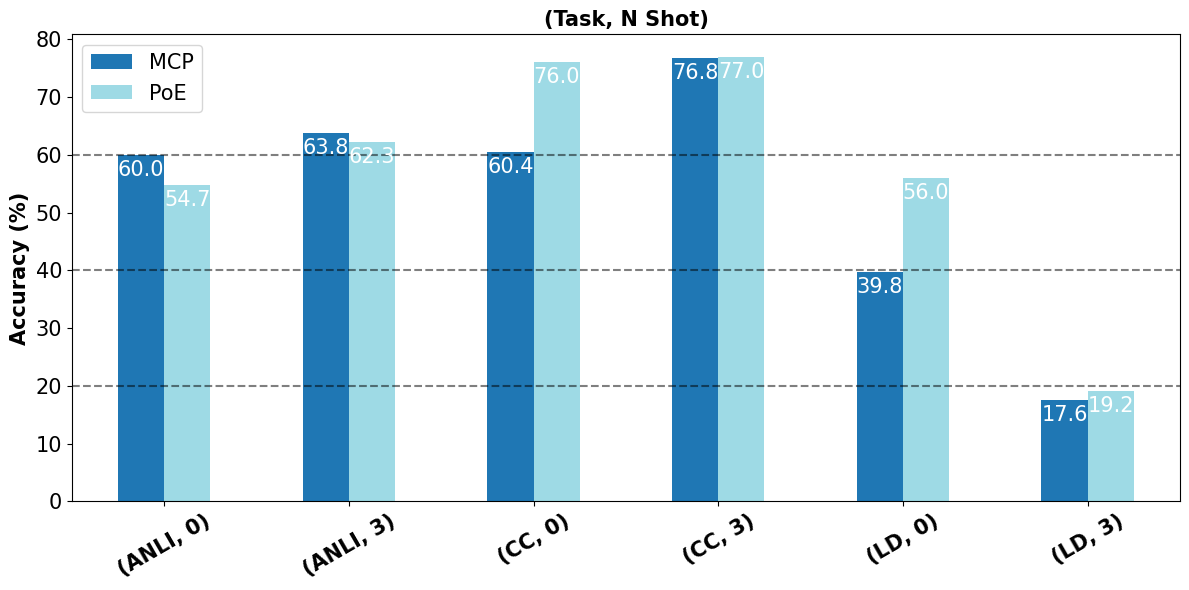

In [32]:

df = temp_df.copy()

# Setting the index for the dataframe to facilitate plotting using df.plot.bar()
df.set_index(['Task', 'N Shot'], inplace=True)

# Plotting using df.plot.bar()
fig, ax = plt.subplots(figsize=(12, 6))
font_size = 15
h_lines = [20, 40, 60] 
df[['MCP', 'PoE']].plot.bar(ax=ax,
                            #  alpha=0.7, 
                            capsize=4, 
                            rot=30,
                            colormap='tab20',
                            )

# set legend
ax.legend(loc='upper left', fontsize=font_size)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size, weight="bold")

ax.set_ylabel("Accuracy (%)", fontsize=font_size, weight="bold")
ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()], fontsize=font_size)

ax.set_title(f"(Task, N Shot)", fontsize=font_size, weight="bold")

# plot numbers on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height() - 5),
                color='white',
                fontsize=font_size,
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.show()
plt.savefig("n_shot.png", dpi=300, bbox_inches='tight')




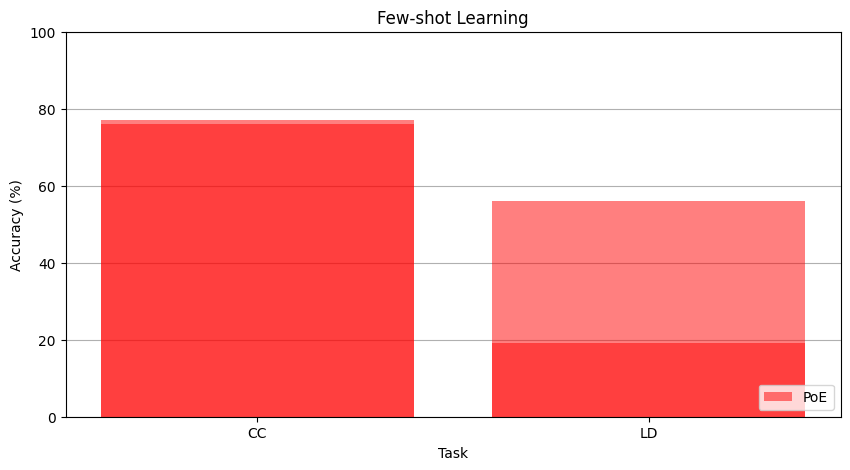

In [ ]:
# bar plot: df
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim(0, 100)
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Task")
ax.set_title("Few-shot Learning")
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.bar(temp_df["Task"], temp_df["PoE"], color="red", alpha=0.5, label="PoE")
ax.bar(temp_df["Task"], temp_df["MCP"], color="blue", alpha=0.5, label="MCP")
ax.legend(loc="lower right")
# plt.savefig("few_shot_v3.png", dpi=300)
plt.show()
